# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"

## Estudiantes: 

- Hernández Mancipe Daniel Felipe
- Panadero de las Heras José Luis 
- Thoux Durán Alejandro Napoleón 
- Velastegui Izurieta Homero Javier 

# **Introducción**

En el presente proyecto se utilizó una instancia **g4dn.2xlarge de** AWS que está diseñada para tareas de aprendizaje automático, inferencia y procesamiento gráfico moderado. Cuenta con 8 vCPUs basadas en procesadores Intel Xeon escalables, 32 GB de memoria RAM y una GPU NVIDIA T4 con 16 GB de memoria de video, lo que permite acelerar modelos de deep learning, análisis de imágenes, renderizado y aplicaciones con CUDA. Además, incluye NVMe local de alto rendimiento (aprox. 225 GB) para acceso rápido a datos temporales, hasta 25 Gbps de ancho de banda de red y soporte para EBS para almacenamiento adicional. Está optimizada para entrenamiento de modelos pequeños o medianos, inferencia en producción, desarrollo de modelos y aplicaciones de visualización 3D.

Dado que se utilizó una instancia remota, algunas etapas del entrenamiento se ejecutaron mediante scripts en Python gestionados con tmux, en lugar de seguir íntegramente la estructura de ejecución típica en Jupyter Notebook. Esto se debe a que Jupyter Lab, aunque útil para exploración, prototipado y visualización, puede interrumpir el entrenamiento si la sesión web se cierra o si existe inestabilidad en la conexión. En cambio, el uso de scripts junto con tmux permite mantener el proceso activo en segundo plano de forma persistente, incluso si el usuario cierra la terminal o el navegador, garantizando continuidad en entrenamientos prolongados.

Por ello, el proyecto se desarrolló de forma híbrida: se realizaron fases de análisis exploratorio, pruebas y visualizaciones en Jupyter Lab, mientras que los entrenamientos definitivos y la ejecución de modelos se llevaron a cabo mediante scripts independientes en la instancia, asegurando estabilidad y reportando los resultados en este documento.


## **a. Descripción del Dataset**

El dataset asignado al Grupo 15 fue **Lemon Quality Dataset**,  este es un conjunto de imágenes orientado a la **clasificación automática de la calidad de limones** mediante técnicas de Visión por Computador y Aprendizaje Profundo. El dataset contiene imágenes capturadas bajo condiciones de iluminación natural y fondos uniformes, lo que facilita su uso en modelos basados en redes neuronales convolucionales (CNNs). Las imágenes muestran limones en diferentes estados de calidad, principalmente **limones en buen estado** y **limones deteriorados**, aunque la versión empleada en este proyecto incluye además una categoría adicional que representa **imágenes sin limón**.

## **b. Estructura y Organización del Dataset**

En la versión utilizada en este proyecto, el dataset está organizado en tres carpetas, cada una correspondiente a una clase de clasificación:

| Carpeta             | Clase               | Descripción                                                                               |
|--------------------|--------------------|-------------------------------------------------------------------------------------------|
| `good_quality`      | Limón en buen estado | Imágenes de limones con apariencia fresca y sin signos visibles de daño o deterioro.      |
| `bad_quality`       | Limón en mal estado  | Imágenes de limones con señales de deterioro, manchas, podredumbre o deformaciones.       |
| `empty_background`  | Fondo vacío         | Imágenes sin limón útil en la escena; actúa como clase de control negativo.               |

Esta estructura permite formular una **tarea de clasificación multiclase**, donde el modelo debe aprender a distinguir visualmente entre limones buenos, limones en mal estado y ausencia de limón.

Aunque el número de imágenes puede variar según la versión descargada, en el presente proyecto la distribución del conjunto es la siguiente:

| Clase               | Nº aproximado de imágenes | Propósito en la clasificación |
|--------------------|--------------------------|------------------------------|
| `good_quality`       | 1125                    | Representa producto apto para comercialización. |
| `bad_quality`        | 952                     | Permite identificar fruta dañada o no apta.      |
| `empty_background`   | 452   | Ayuda al modelo a descartar imágenes irrelevantes. |

## **c. Objetivo del Dataset en el Contexto del Proyecto**

El objetivo central del dataset es **servir como base para el entrenamiento, validación y evaluación de modelos de clasificación de imágenes** que permitan determinar automáticamente el estado de calidad de un limón. Este problema es una tarea de **clasificación visual aplicada**, donde las características que diferencian categorías son sutiles (manchas, textura de la cáscara, coloración, etc.).

En este proyecto, el dataset se empleará para comparar dos estrategias de aprendizaje profundo:

1. **Entrenamiento desde cero (from scratch):**  
   Se diseña y entrenará una CNN personalizada, aplicando técnicas de regularización, ajuste de hiperparámetros y data augmentation para optimizar el rendimiento.

2. **Transfer Learning con redes preentrenadas en ImageNet:**  
   Se utilizara arquitecturas profundas como **VGG, ResNet, MobileNet o Inception**, realizando ajuste fino (fine-tuning) para adaptar la red a la tarea específica de clasificación de limones.


## **d. Importar las librerías necesarias**

Para facilitar la reproducción de la práctica, en la raíz del proyecto se ha incluido el fichero requirements.txt, el cual contiene todas las dependencias necesarias. La instalación puede realizarse desde una terminal ubicada en la raíz del proyecto mediante el siguiente comando:

```bash
pip install -r requirements.txt
```

En la sección siguiente se procederá a importar tanto las librerías requeridas como los módulos correspondientes a las clases personalizadas desarrolladas para este proyecto.

**Librerías y Dependencias**


In [1]:
from importlib import reload

**Dependencias**

In [2]:
import numpy as np
import pandas as pd
#import seaborn as sns

**Clases Personalizadas**

In [3]:
import modulos.lemon_cnn_model as lemon_cnn_model_module
import modulos.lemon_dataset as lemon_dataset_module
import modulos.lemon_evaluator as lemon_evaluator_module
import modulos.lemon_genloader as lemon_genloader_module
import modulos.lemon_tfloader as lemon_tfloader_module

reload(lemon_cnn_model_module)
reload(lemon_dataset_module)
reload(lemon_evaluator_module)
reload(lemon_genloader_module)
reload(lemon_tfloader_module)

from modulos.lemon_cnn_model import LemonCNNBuilder
from modulos.lemon_dataset import LemonDataset
from modulos.lemon_evaluator import LemonEvaluator
from modulos.lemon_genloader import LemonGenLoader
from modulos.lemon_tfloader import LemonTFLoader


lemon_dataset=LemonDataset()


2026-01-11 14:27:08.191797: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-11 14:27:08.192054: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-11 14:27:08.230004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-11 14:27:09.094459: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

---

# **Desarrollo**

El desarrollo del proyecto se realizó aplicando el paradigma de programación orientada a objetos. Para ello, se creó un directorio denominado modulos/, el cual contiene las clases que encapsulan la lógica necesaria para la carga de datos, el preprocesamiento, la construcción de modelos y el entrenamiento.
A lo largo de este informe, en cada sección se muestran únicamente las llamadas a los métodos correspondientes de dichas clases, con el fin de mantener el flujo del notebook claro y enfocado en el proceso experimental.

Adicionalmente, al final del documento se incluirá el código completo de las clases desarrolladas, con el propósito de proporcionar una visión integral y transparente de la solución implementada. 

## **1. Carga de datos desde la plataforma Kaggle**

En primer lugar se genera un API de Kaggle personal, para ello:
1. Registrarse en  https://www.kaggle.com
2. Ir a 'Account tab' del perfil y seleccionar 'Create API Token', se descargará un `fichero kaggle.json`
3. Guardar el fichero kaggle.json en el directorio `~/.config/kaggle/kaggle.json` de la instancia en la que se ejecutará el entrenamiento.

Una vez colocado el token de acceso de Kaggle, es necesario instalar en la instancia la API, para ello en la terminal de Linux ejecutar:

```bash
pip install kaggle
```

Se puede verificar la instalación con el comando `kaggle datasets list`, si todo está configurado de manera correcta se obtendrá el listado de datasets disponibles. En el caso de que existan problemas, se debe verificar la ruta del archivo kaggle.json. Una vez verificado el acceso se procede a obtener el dataset, para ello se debe ejecutar en la terminal de Linux dentro del directorio del proyecto:

```bash
kaggle datasets download -d yusufemir/lemon-quality-dataset
unzip lemon-quality-dataset.zip
rm lemon-quality-dataset.zip
```

Al finalizar se debe tener un directorio con el dataset esperado con una estructura similar a la siguiente:

```bash
lemon_dataset/
│
├── bad_quality
├── empty_background
└── good_quality
```

Podemos validar la carga del dataset con el siguiente comando:


In [4]:
!ls lemon_dataset

bad_quality  empty_background  good_quality


## **2. Inspección del Dataset**

Para realizar una primera exploración del conjunto de datos, se emplearon los métodos provistos en la clase `LemonDataset`.  
Estos permiten obtener una visión general sobre la distribución, variabilidad y características de las imágenes:

- **`class_counter()`**: calcula cuántas imágenes hay por clase, ayudando a identificar posibles desbalances.
- **`show_grid_per_class(n)`**: muestra `n` ejemplos por clase, facilitando la inspección visual.
- **`check_image_shapes()`**: verifica las dimensiones de las imágenes, útil para determinar si es necesario redimensionar antes del entrenamiento.

A continuación, se presentan los resultados de esta inspección.


,Clase,Cantidad
0,bad,951
1,empty,452
2,good,1125


,"Dimensiones (H,W,C)",Cantidad
0,"(300, 300, 3)",2526
1,"(292, 300, 3)",1
2,"(300, 296, 3)",1


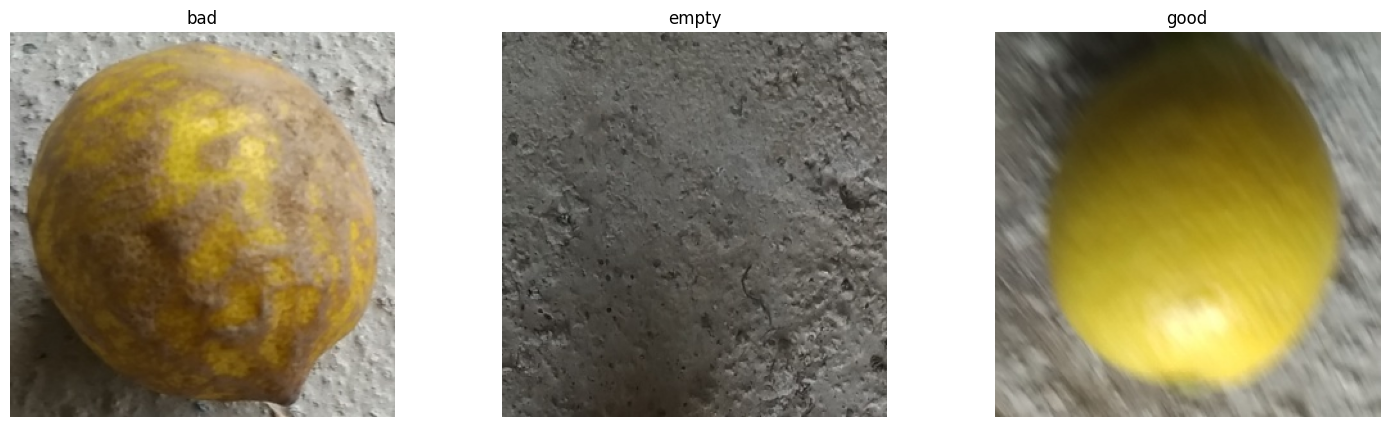

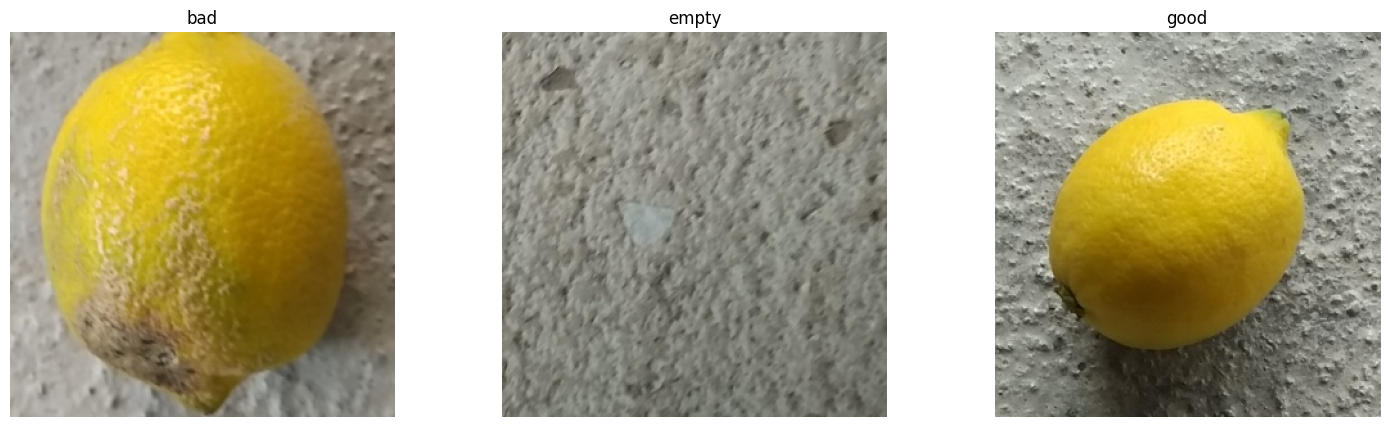

In [5]:
lemon_dataset.class_counter()
lemon_dataset.show_grid_per_class(2)
lemon_dataset.check_image_shapes()

El conjunto de datos utilizado en este proyecto fue obtenido de la plataforma Kaggle y está compuesto por imágenes de limones categorizadas en tres clases: **good_quality** (limones en buen estado), **bad_quality** (limones deteriorados) y **empty_background** (imágenes donde no aparece el fruto, utilizadas como distractores).  
El propósito de esta inspección es analizar la distribución de las clases, observar las características visuales de las imágenes y detectar posibles factores que puedan influir en el rendimiento del modelo durante el proceso de aprendizaje. Entre estos factores se consideran variaciones de iluminación, textura, enfoque, orientación y condiciones de captura en general.

### 2.1. Distribución de imágenes por clase

La siguiente tabla muestra la cantidad de muestras disponibles por categoría:

| Clase | Cantidad |
|------|---------|
| bad_quality | 951 |
| empty_background | 452 |
| good_quality | 1125 |

Se aprecia una distribución moderadamente desbalanceada entre clases, destacando que la categoría *empty_background* contiene un número menor de imágenes. Este desbalanceo podría influir en la capacidad del modelo para aprender representaciones adecuadas de dicha clase, por lo que será considerado durante el entrenamiento mediante el uso de técnicas de *data augmentation* y regularización para evitar sesgos hacia las clases mayoritarias.

### 2.2. Inspección visual de las imágenes

Con el fin de explorar la variabilidad intra-clase, se visualizaron múltiples imágenes pertenecientes a cada categoría. En el presente informe se incluyen únicamente **dos imágenes representativas por clase**, aunque durante la fase de análisis se revisaron diversas muestras adicionales para detectar patrones consistentes en textura, color, forma y condiciones de iluminación.

Las observaciones principales fueron las siguientes:

- Las imágenes de la clase **good_quality** presentan limones con color uniforme, textura regular y forma bien definida.
- Las imágenes pertenecientes a la clase **bad_quality** incluyen limones con manchas oscuras, zonas deterioradas, irregularidades en la superficie y variaciones de tono, lo que proporciona señales visuales útiles para la clasificación.
- Las imágenes de la clase **empty_background** muestran superficies rugosas y homogéneas (generalmente paredes), aunque con variaciones en luz y contraste que pueden generar cierto nivel de ambigüedad si el objeto aparece desenfocado o con bajo contraste respecto al fondo.

### 2.3. Tamaño y consistencia de las imágenes

El análisis de las dimensiones del conjunto de imágenes arrojó los siguientes resultados:

| Dimensiones (H,W,C) | Cantidad |
|--------------------|----------|
| (300, 300, 3)      | 2526     |
| (292, 300, 3)      | 1        |
| (300, 296, 3)      | 1        |

Se concluye que el dataset es **prácticamente uniforme** en términos de resolución, con solo dos imágenes ligeramente divergentes. No obstante, con el fin de mantener una **comparación justa** entre la estrategia de entrenamiento desde cero y los modelos basados en *transfer learning*, se decidió **redimensionar todas las imágenes a 224×224 píxeles** durante el pipeline de carga de datos. Este tamaño es el estándar utilizado en modelos pre-entrenados sobre ImageNet y contribuye a reducir el coste computacional, además de mitigar el riesgo de sobreajuste cuando se trabaja con conjuntos de datos de tamaño medio.

### 2.4. Resultados de la inspección

El dataset presenta una variabilidad visual suficiente para permitir el aprendizaje de patrones que diferencien las tres clases. Sin embargo, el desbalanceo de la clase *empty_background* y la presencia de variaciones en iluminación y textura hacen necesario aplicar estrategias de **data augmentation** y **regularización** para mejorar la capacidad de generalización del modelo. El uso de un **tamaño de entrada uniforme de 224×224 píxeles** permitirá asegurar la compatibilidad con arquitecturas pre-entrenadas y optimizar el rendimiento computacional durante las etapas de entrenamiento y evaluación.


## **3. Acondicionamiento del Conjunto de Datos**

Con el objetivo de preparar el dataset para el entrenamiento de los modelos, se desarrolló una estructura modular basada en programación orientada a objetos. Esta estructura permite gestionar el conjunto de imágenes, generar particiones de entrenamiento/validación/test con estratificación de clases y aplicar técnicas de *data augmentation* adaptadas a cada estrategia experimental.


### 3.1. Clase `LemonDataset`

La clase `LemonDataset` constituye el componente base del *pipeline* de datos y centraliza toda la lógica asociada a la carga, organización y preparación del conjunto de imágenes. Su objetivo es abstraer el acceso al *dataset* y proporcionar una representación adecuada y reutilizable de los datos a lo largo de las distintas etapas del proceso de entrenamiento y evaluación del modelo.

En esta clase se definen las rutas correspondientes a cada una de las categorías del problema de clasificación (`bad_quality`, `good_quality` y `empty_background`). A partir de esta estructura, el sistema recorre de forma sistemática los directorios y construye en memoria un *dataframe* que almacena, para cada muestra, la ruta completa de la imagen junto con su etiqueta de clase, facilitando así posteriores procesos de análisis, filtrado y particionado.

Una vez estructurados los datos, `LemonDataset` realiza una división estratificada del conjunto completo, asegurando que la proporción de cada clase se mantenga en todos los subconjuntos. Por defecto, esta partición se distribuye en un **70 % para entrenamiento**, un **15 % para validación** y un **15 % para prueba**, lo que permite un flujo de trabajo equilibrado entre aprendizaje, ajuste de hiperparámetros y evaluación final.

De manera adicional, la clase incorpora el parámetro `mode`, destinado a controlar la intensidad de las operaciones de *data augmentation* aplicadas a las imágenes. Este parámetro permite adaptar el mismo *dataset* a las diferentes estrategias de entrenamiento; con configuraciones agresivas orientadas para el entrenamiento desde cero (`modo scratch`), y transformaciones más conservadoras para escenarios de *transfer learning* o *fine tuning* en el modo `transfer`. 

| Modo | Uso previsto | Intensidad de *data augmentation* |
|------|--------------|-----------------------------------|
| `scratch` | Entrenamiento desde cero | Fuerte |
| `transfer` | *Transfer learning* / *fine tuning* | Moderada |


En función del modo seleccionado, la clase asigna de manera automática valores a los parámetros como el rango de rotación, el nivel de *zoom*, los ajustes de brillo y el contraste. En la clase se establecen estos valores con las siguientes constantes:

| Técnica | `scratch` (desde cero) | `transfer` (transfer learning) |
|--------|------------------------|--------------------------------|
| Brillo (`brightness_range`) | 0.7 – 1.3 (±30 %) | 0.9 – 1.1 (±10 %) |
| Brillo fino (`max_delta`) | ±0.15 | ±0.07 |
| Contraste (`contrast_range`) | 0.8 – 1.2 | 0.9 – 1.1 |
| Zoom global (`zoom_range`) | 0.75 – 1.0 | 0.07 (factor pequeño) |
| Zoom local (`zoom_ratio`) | 0.85 – 0.95 | 0.90 – 0.98 |
| Rotaciones (`rotation_range`) | Hasta 20° | Hasta 10° |

En el escenario de entrenamiento desde cero, el modelo no dispone de representaciones previas y debe aprender desde etapas muy tempranas características de bajo y medio nivel. Por esta razón, se emplea una augmentación más intensa, incorporando variaciones amplias en brillo, contraste, rotación y *zoom*. Este enfoque incrementa la diversidad efectiva del conjunto de entrenamiento y favorece la capacidad de generalización del modelo frente a variaciones no vistas durante el aprendizaje.

En contraste, en el contexto de *transfer learning*, el modelo parte de representaciones semánticas previamente aprendidas sobre grandes volúmenes de datos. En este caso, una augmentación excesiva podría alterar o degradar dichas representaciones, afectando negativamente el proceso de *fine tuning*. Por ello, se aplican transformaciones más suaves y controladas, limitando los rangos de rotación, brillo, contraste y *zoom*, con el objetivo de adaptar el modelo al nuevo dominio sin introducir distorsiones innecesarias.


### 3.2. Cargadores de Imágenes

Para la carga y acondicionamiento del *dataset* se implementaron dos métodos complementarios, con el objetivo de evaluar tanto el rendimiento predictivo de los modelos como la eficiencia computacional del pipeline de entrada de datos. Ambos enfoques fueron analizados durante las etapas iniciales de entrenamiento de la **Estrategia 1**, y el método que presentó mejores resultados fue posteriormente seleccionado para el entrenamiento de la **Estrategia 2**.

Con este propósito, se diseñaron dos clases especializadas que extienden la funcionalidad base definida en `LemonDataset`. Cada una de ellas implementa un pipeline de carga distinto, adaptado a escenarios específicos de entrenamiento, manteniendo una separación clara entre la lógica de particionado del conjunto de datos y la generación de flujos o *datasets* para el modelo.

### a. Cargador basado en `ImageDataGenerator`: Clase `LemonGenLoader`

La clase `LemonGenLoader` extiende `LemonDataset` y se apoya en `ImageDataGenerator` de Keras para construir flujos de datos directamente compatibles con el método `model.fit()`. Este enfoque permite aplicar *data augmentation* en tiempo de entrenamiento de forma sencilla y controlada, lo que resulta útil durante las fases iniciales de desarrollo del modelo.

Las características principales de este cargador son:

- Redimensionamiento uniforme de las imágenes a **224×224** píxeles.
- Normalización automática de los valores de intensidad mediante `rescale=1/255`.
- Aplicación de *data augmentation* exclusivamente sobre el conjunto de entrenamiento.
- Uso de conjuntos de validación y test sin augmentación y sin mezcla (`shuffle=False`), con el fin de preservar la consistencia y comparabilidad de las métricas de evaluación.

Las transformaciones aplicadas en este método incluyen el reescalado de intensidades, rotaciones aleatorias, variaciones de brillo, *zoom* aleatorio y volteo horizontal. Este conjunto de transformaciones facilita la inspección visual y el ajuste intuitivo de los parámetros de augmentación, permitiendo analizar cómo la variabilidad inducida afecta la capacidad del modelo para generalizar.

La división del dataset en los conjuntos de entrenamiento, test y validación con este cargador se puede realizar utilizando el siguiente código:

In [6]:
lemon_genloader=LemonGenLoader()
lemon_genloader._create_splits()
train_gen, val_gen, test_gen=lemon_genloader.get_generators()

Found 316 validated image filenames belonging to 3 classes.
Found 1453 validated image filenames belonging to 3 classes.
Found 379 validated image filenames belonging to 3 classes.
Found 380 validated image filenames belonging to 3 classes.


### b. Cargador basado en `tf.data`: Clase `LemonTFLoader`

El segundo pipeline implementado se basa en la API `tf.data`, la cual permite construir pipelines de datos optimizados para el uso eficiente de CPU y GPU. Este enfoque es adecuado para escenarios donde se trabaja con arquitecturas profundas y grandes volúmenes de datos.

Este pipeline realiza de forma estructurada las siguientes operaciones:

1. Lectura de rutas de imagen a partir de listas en formato numpy.
2. Decodificación de las imágenes y normalización en formato tensor.
3. Redimensionamiento uniforme a **224×224×3** (por defecto, es posible configurar los valores de resolución en la creación de la instancia.
4. Aplicación de *data augmentation* mediante transformaciones tensoriales, tales como volteo horizontal, ajustes de brillo y contraste, y *zoom* suave mediante `tf.image.central_crop`.
5. Agrupamiento de las muestras en lotes (`batch_size = 32`).
6. Carga anticipada de los datos mediante `prefetch`, permitiendo superponer el preprocesamiento y el entrenamiento.

Este enfoque incorpora optimizaciones propias de `tf.data`, como el uso de `map` con operaciones vectorizadas, `shuffle` para evitar sesgos derivados del orden de los datos y una gestión eficiente de los lotes. Estas características reducen la latencia durante el entrenamiento y evitan cuellos de botella en la lectura y transformación de las imágenes.

El uso de `LemonTFLoader` permite obtener los conjuntos de entrenamiento, test y validación mediante la ejecución de los siguientes comandos:

In [7]:
lemon_tfloader=LemonTFLoader()
lemon_tfloader._create_splits()
train_ds, val_ds, test_ds=lemon_tfloader.get_datasets()

display(train_ds)
display(val_ds)
display(test_ds)


2026-01-11 12:13:39.093704: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

## **4. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución**

### 4.1 Estrategia 1: Entrenar desde cero o from scratch

### a. Arquitectura propuesta para el modelo entrenado desde cero (from scratch)

Para la primera estrategia se diseñó una red neuronal convolucional profunda siguiendo un enfoque moderno basado en **convoluciones separables** (SeparableConv2D). A diferencia de la convolución estándar, la convolución separable descompone la operación en una convolución *depthwise* (por canal) seguida de una convolución *pointwise* (1×1). Esta descomposición reduce el número de parámetros y el coste computacional, manteniendo la capacidad representativa del modelo. Esta técnica es empleada en arquitecturas consolidadas como **MobileNet** y **Xception**, lo que justifica su elección.

El modelo propuesto está estructurado en cuatro bloques jerárquicos de extracción de características, donde el número de filtros aumenta progresivamente (32 → 64 → 128 → 256). Este incremento gradual permite que las capas profundas aprendan patrones cada vez más complejos:

- **Bloque 1:** aprendizaje de bordes y contornos básicos.
- **Bloque 2:** modelado de texturas locales.
- **Bloque 3:** captación de irregularidades morfológicas relacionadas con la calidad del fruto.
- **Bloque 4:** identificación de patrones estructurales que permiten distinguir limones en buen estado, deteriorados o ausencia de objeto.

Cada bloque contiene dos capas `SeparableConv2D` seguidas de `BatchNormalization` y activación `ReLU`, lo que estabiliza la distribución de activaciones y acelera la convergencia durante el entrenamiento. Posteriormente se aplica `MaxPooling2D` para reducir la dimensionalidad espacial y un `Dropout` progresivo (0.25 → 0.40) como mecanismo de regularización para prevenir el sobreajuste.

En lugar de emplear una capa `Flatten`, se utiliza `GlobalAveragePooling2D`. Esta decisión evita la explosión de parámetros y favorece que la red aprenda representaciones globales en lugar de memorizar patrones locales. La capa densa final incorpora regularización **L2**, lo cual penaliza pesos excesivamente grandes y contribuye a mejorar la capacidad de generalización del modelo.

Finalmente, la capa de salida es una capa `Dense` con **activación Softmax**, adecuada para problemas de clasificación multiclase con categorías mutuamente excluyentes, ya que convierte las salidas del modelo en probabilidades normalizadas. La función de pérdida utilizada es **`categorical_crossentropy`**, coherente con la codificación one-hot de las etiquetas.

### b. Construcción del Modelo

La arquitectura propuesta se implementó como una **solución reusable y parametrizable** mediante el módulo `lemon_cnn_model`, el cual encapsula la lógica de construcción en la clase **`LemonCNNBuilder`**. En lugar de definir la red directamente en el mismo script de entrenamiento, se adopta el patrón *builder* para separar responsabilidades: el proceso de entrenamiento se concentra en la carga de datos, compilación y ajuste de hiperparámetros, mientras que el builder se encarga de **generar la topología del modelo** de forma consistente y reproducible.

La clase `LemonCNNBuilder` recibe como parámetros principales el **tamaño de entrada** (`input_shape=(224,224,3)`) y el **número de clases** (`num_classes=3`). Esta parametrización permite reutilizar la misma implementación ante variaciones del dataset o del problema (por ejemplo, cambiar la resolución de entrada o el número de categorías) sin reescribir la arquitectura. Internamente, la clase define el método auxiliar `_sep_block`, el cual representa el componente base de extracción de características: dos capas `SeparableConv2D` consecutivas (cada una seguida de `BatchNormalization` y activación `ReLU`), posteriormente una reducción espacial mediante `MaxPooling2D`, y finalmente `Dropout` como mecanismo de regularización. Este enfoque modular convierte a cada bloque en una unidad fácilmente replicable y ajustable, manteniendo claridad estructural y control sobre la complejidad del modelo.

El método `build()` ensambla el modelo completo conectando cuatro bloques separables con un crecimiento progresivo del número de filtros (32 → 64 → 128 → 256). Una vez finalizada la extracción jerárquica de características, se aplica `GlobalAveragePooling2D` para condensar los mapas de activación en un vector compacto, evitando el incremento excesivo de parámetros que implicaría una capa `Flatten`. A continuación, se incorpora una capa densa intermedia de 128 neuronas con activación ReLU y regularización **L2** (`l2(0.001)`), seguida de `Dropout`, y finalmente una capa de salida `Dense` con activación **Softmax** para generar probabilidades normalizadas sobre las tres clases.

La construcción efectiva del modelo se realiza instanciando el builder y generando un objeto `tf.keras.Model` listo para ser compilado y entrenado, tal como se muestra a continuación:


In [8]:
from tensorflow.keras.optimizers import Adam

builder = LemonCNNBuilder(input_shape=(224,224,3), num_classes=3)
model = builder.build()
model.summary()

Model: "lemon_cnn_separable"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 224, 224, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 224, 224, 32)   │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 112, 112, 64)   │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 112, 112, 64)   │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 56, 56, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 128)    │             

 Total params: 174,590 (681.99 KB)

 Trainable params: 172,670 (674.49 KB)

 Non-trainable params: 1,920 (7.50 KB)

El `model.summary()` permite inspeccionar la estructura resultante capa por capa (dimensiones y número de parámetros), aportando trazabilidad y verificación explícita de la arquitectura utilizada en la `Estrategia 1`. Esta organización mejora la mantenibilidad del proyecto, ya que cualquier cambio en la topología puede realizarse centralizadamente en el builder sin afectar el resto del pipeline.

### c. Entrenamiento del modelo

El entrenamiento del modelo se ejecutó en una instancia **AWS EC2 `g4dn.2xlarge`**, seleccionada por ofrecer un entorno estable con aceleración por GPU para experimentos de visión por computador y un balance adecuado entre capacidad de cómputo y coste. Esta infraestructura permitió entrenar la red desde cero de manera repetida y controlada, garantizando tiempos de ejecución razonables y consistencia en los resultados obtenidos.

Con el objetivo de analizar el impacto del *pipeline* de entrada de datos en el comportamiento del modelo, se emplearon los **dos cargadores de datos** definidos en el apartado 3 de este informe: un flujo basado en **`ImageDataGenerator`** y otro basado en **`tf.data.Dataset`**. Para evitar duplicación de código y asegurar que ambos enfoques compartieran exactamente la misma arquitectura, optimizador, función de pérdida y esquema de callbacks, se diseñó el módulo **`modulos/lemon_trainer.py`**, el cual centraliza toda la lógica del entrenamiento en una única clase.

La clase **`LemonTrainer`** actúa como un **entrenador unificado**, encapsulando el flujo completo del experimento supervisado. A partir de un objeto de configuración (`TrainerConfig`), el entrenador decide de forma transparente qué estrategia de carga utilizar (`gen` o `tf`), prepara los subconjuntos de entrenamiento, validación y prueba, construye la arquitectura definida por `LemonCNNBuilder`, compila el modelo y ejecuta el entrenamiento. De esta forma, la comparación entre ambos *loaders* se realiza bajo condiciones estrictamente controladas, eliminando sesgos derivados de diferencias en la implementación del entrenamiento.

Durante la fase de preparación de datos, `LemonTrainer` delega la creación de los *datasets* al cargador correspondiente, manteniendo proporciones fijas para los conjuntos de validación y prueba y utilizando una semilla para asegurar reproducibilidad. Posteriormente, el modelo se construye mediante la API funcional de Keras y se compila con el optimizador **Adam**, una tasa de aprendizaje inicial configurable y la función de pérdida **`categorical_crossentropy`**, coherente con el problema de clasificación multiclase.

El proceso de entrenamiento se apoya en un conjunto de **callbacks** diseñados para mejorar la estabilidad y la eficiencia del aprendizaje. En particular, se emplea **EarlyStopping** para detener el entrenamiento cuando la pérdida de validación deja de mejorar, **ReduceLROnPlateau** para disminuir dinámicamente la tasa de aprendizaje ante estancamientos en la optimización y **ModelCheckpoint** para almacenar automáticamente el modelo con mejor desempeño en validación. Esta combinación permite mitigar el sobreajuste y favorece la convergencia hacia soluciones con mejor capacidad de generalización.

Una vez finalizado el entrenamiento, el modelo se evalúa sobre el conjunto de prueba independiente, obteniendo métricas finales de pérdida y exactitud. Adicionalmente, el entrenador genera y almacena las curvas de pérdida y *accuracy* (entrenamiento vs. validación), las cuales resultan fundamentales para el análisis posterior del comportamiento del modelo y la detección de problemas como sobreajuste u oscilaciones durante el aprendizaje.

#### Ejecución del entrenamiento en la instancia: scripts `gen_run.py` y `tf_run.py`

Para ejecutar los experimentos de forma automatizada en la instancia de AWS se implementaron dos scripts de corrida, cada uno orientado a un *loader* específico pero compartiendo la misma lógica experimental:

- **`gen_run.py`**: ejecuta múltiples entrenamientos configurando `TrainerConfig(loader='gen')`, es decir, utilizando el flujo basado en **`ImageDataGenerator`**.
- **`tf_run.py`**: ejecuta múltiples entrenamientos configurando `TrainerConfig(loader='tf')`, es decir, utilizando el flujo basado en **`tf.data.Dataset`**.

Ambos scripts tienen el mismo objetivo metodológico: **realizar varias corridas independientes (runs)** del entrenamiento *from scratch* bajo los mismos hiperparámetros (por defecto, 40 épocas y `learning_rate=1e-3`) para estimar no solo el desempeño promedio, sino también la **variabilidad entre corridas**. Este enfoque es útil porque en entrenamiento profundo existen fuentes de aleatoriedad (inicialización de pesos, orden de batches, particionado de datos, etc.) que pueden producir fluctuaciones de desempeño aun cuando la configuración sea la misma.

En términos operativos, `gen_run.py` y `tf_run.py` implementan los siguientes pasos:

1. **Configuración del experimento (una sola vez):**  
   Se construye un objeto `TrainerConfig` con el *loader* correspondiente, el número de épocas y la tasa de aprendizaje. Esta configuración se reutiliza en todas las corridas, garantizando consistencia.

2. **Ejecución iterativa de corridas (`runs`):**  
   Se ejecuta un bucle que crea un `LemonTrainer` por corrida y llama a `run_trainer()`. Cada corrida se identifica con un `attempt_id` (por ejemplo, `01`, `02`, ..., `10`), lo que permite organizar salidas y artefactos (modelo, gráficas) por intento.

3. **Manejo de errores por corrida:**  
   Si una corrida falla (por ejemplo, por un error de lectura, memoria o un fallo del proceso), el script registra el error con `logging.exception(...)` y guarda `NaN` como marcador. De esta manera, una falla puntual no detiene el experimento completo.

4. **Extracción de métricas clave:**  
   Tras cada entrenamiento, los scripts capturan:
   - `test_accuracy` desde el diccionario retornado por `run_trainer()`.
   - `val_accuracy` final desde `trainer.history`, tomando el último valor de la curva de validación.  
   Esto permite analizar el desempeño en validación (durante el ajuste) y en prueba (generalización).

5. **Cálculo de estadísticos entre corridas:**  
   Al finalizar las ejecuciones, se calculan estadísticos ignorando `NaN`:
   - **media**, **varianza** y **desviación estándar** para `test_accuracy` y `val_accuracy`.  
   Este resumen cuantifica la estabilidad del entrenamiento: una varianza baja sugiere resultados consistentes entre corridas; una varianza alta indica sensibilidad a la aleatoriedad o a la configuración del entrenamiento.

6. **Persistencia de resultados:**  
   Finalmente, ambos scripts guardan los vectores de métricas por corrida en formato `.npy`:
   - `results_gen/test_accs.npy` y `results_gen/val_accs.npy` para el caso `gen_run.py`.
   - `results_tf/test_accs.npy` y `results_tf/val_accs.npy` para el caso `tf_run.py`.  
   Estos archivos permiten análisis posteriores (comparación directa entre loaders, pruebas estadísticas, gráficas agregadas, etc.) sin necesidad de reentrenar.

Estos scripts constituyen la capa de **orquestación experimental** sobre `LemonTrainer`: automatizan la repetición de entrenamientos, registran métricas por corrida y generan insumos cuantitativos para comparar ambos pipelines (ImageDataGenerator vs. tf.data) por desempeño máximo, **robustez y reproducibilidad** del proceso de entrenamiento.

Los resultados de la primera ejecución del entrenamiento con los dos loaders, se presentan a continuación:


In [9]:
results={
    'TF Testing' : np.load("results_tf/init/test_accs.npy", allow_pickle=True),
    'GEN Testing' : np.load("results_gen/init/test_accs.npy", allow_pickle=True),
    'TF Validation'  : np.load("results_tf/init/val_accs.npy", allow_pickle=True),
    'GEN Validation'  : np.load("results_gen/init/val_accs.npy", allow_pickle=True)
    }

df_results=pd.DataFrame(results)

display(df_results)


,TF Testing,GEN Testing,TF Validation,GEN Validation
0,1.000000,0.989474,0.973615,0.994723
1,0.997368,0.989474,0.989446,0.986807
2,0.997368,0.994737,1.000000,0.997361
3,0.997368,0.989474,1.000000,0.960422
4,0.984211,0.968421,0.976253,0.957784
5,0.997368,0.994737,0.986807,0.986807
6,0.989474,0.981579,0.883905,0.973615
7,0.997368,0.986842,0.994723,0.978892
8,0.997368,0.994737,1.000000,0.992084
9,0.968421,0.978947,0.947230,0.963061


In [10]:
summary = pd.concat(
    [
        df_results.mean().rename("mean"),
        df_results.std().rename("std"),
        df_results.max().rename("best"),
        df_results.min().rename("min"),
    ],
    axis=1
)

display(summary)


,mean,std,best,min
TF Testing,0.992632,0.009752,1.000000,0.968421
GEN Testing,0.986842,0.008414,0.994737,0.968421
TF Validation,0.975198,0.036032,1.000000,0.883905
GEN Validation,0.979156,0.014741,0.997361,0.957784


De manera adicional, se puede observar las gráficas de estos entrenamientos en el directorio `res_scratch`, mostrando como ejemplo los siguientes:

| Loader TF | Loader GEN | 
|-----------| ----------|
| ![Entrenamiento TF](res_scratch/tf_init/01_history.png) |![Entrenamiento GEN](res_scratch/gen_init/01_history.png)|

| Screenshot TF | Screenshot GEN |
|-----------|-----------|
|  ![Entrenamiento SCT](results_tf/init/screenshot.png)|![Entrenamiento SCG](results_gen/init/screenshot.png)|


## 4.2 Estrategia 2: Red preentrenada (Transfer Learning)

Con el fin de evaluar una estrategia alternativa al entrenamiento desde cero, se implementó una **segunda estrategia basada en transfer learning**, aprovechando modelos convolucionales profundos preentrenados sobre **ImageNet**. Esta aproximación permite reutilizar representaciones visuales genéricas ya aprendidas (bordes, texturas, patrones de alto nivel), reduciendo el tiempo de convergencia y mejorando el desempeño cuando el tamaño del dataset es limitado.

A diferencia de la `Estrategia 1`, donde todos los pesos se inicializan de manera aleatoria, en esta estrategia se parte de un **modelo base preentrenado** y se adapta a la tarea específica de clasificación de limones mediante una cabeza clasificadora ligera y un proceso posterior de *fine-tuning* controlado.

### a. Arquitectura propuesta para el modelo basado en transfer learning

La arquitectura de la Estrategia 2 se compone de dos partes:

1. **Modelo base preentrenado (feature extractor)**  
   Se emplean arquitecturas consolidadas disponibles en `tf.keras.applications`, entre ellas se puede seleccionar:
   - ResNet50  
   - Xception  
   - InceptionV3  
   - MobileNetV2  
   - DenseNet121  

   Estos modelos se cargan con pesos preentrenados en ImageNet, excluyendo la cabeza original de clasificación (`include_top=False`). En esta fase, el modelo base actúa como un **extractor de características**, produciendo mapas de activación de alto nivel a partir de las imágenes de entrada.

2. **Cabeza clasificadora personalizada (top classifier)**  
   Sobre la salida del modelo base se añade una cabeza ligera diseñada específicamente para el problema:
   - `GlobalAveragePooling2D`, para reducir la dimensionalidad espacial sin introducir un gran número de parámetros.
   - `BatchNormalization`, que estabiliza la distribución de activaciones.
   - Capas `Dropout`, como mecanismo de regularización para reducir el sobreajuste.
   - Una capa densa intermedia de 128 neuronas con activación ReLU y regularización L2.
   - Una capa final `Dense` con activación **Softmax**, adecuada para clasificación multiclase con etiquetas mutuamente excluyentes.

Este diseño mantiene un equilibrio entre **capacidad representativa** y **eficiencia computacional**, aprovechando el conocimiento previo del modelo base y adaptándolo de forma controlada al dominio específico del problema.

### b. Construcción del modelo

La construcción del modelo se encapsuló en la clase **`LemonTransferTrainer`**, la cual **extiende directamente `LemonTrainer`**, reutilizando el mismo flujo general de entrenamiento definido para la `Estrategia 1`. De esta forma, se garantiza coherencia metodológica entre ambas estrategias y se evita duplicación innecesaria de lógica.

La clase `LemonTransferTrainer` introduce los siguientes elementos adicionales:

- **Selección dinámica de arquitectura**:  
  A través del parámetro `architecture`, el entrenador puede instanciar diferentes modelos base (ResNet50, MobileNetV2, etc.) sin modificar el resto del pipeline.
- **Preprocesamiento específico por arquitectura**:  
  Cada modelo preentrenado requiere una función `preprocess_input` particular. Esta se inyecta directamente en el `LemonTFLoader`, asegurando que las imágenes sean normalizadas de forma coherente con el entrenamiento original del modelo base.
- **Congelación inicial del modelo base**:  
  Al construir el modelo, todas las capas del backbone se marcan como no entrenables (`trainable = False`), de modo que se entrenan solo los pesos de la cabeza clasificadora en la primera fase.

El modelo completo se construye mediante la API funcional de Keras, conectando explícitamente el modelo base con la cabeza personalizada, y quedando listo para su compilación y entrenamiento dentro del flujo heredado de `LemonTrainer`. En este caso, a continuación se presenta un ejemplo de su implementación:

### c. Entrenamiento del modelo

El entrenamiento del modelo mediante transfer learning se realiza en **dos fases**, ambas orquestadas desde el método `train()` sobrescrito en `LemonTransferTrainer`:

1. **Fase 1: Entrenamiento de la cabeza clasificadora**  
   En esta etapa, el modelo base permanece completamente congelado y solo se entrenan las capas añadidas en la parte superior.  
   - Optimizador: Adam con una tasa de aprendizaje moderada (por defecto `1e-4`).
   - Objetivo: adaptar rápidamente la cabeza clasificadora a la tarea específica sin alterar las representaciones aprendidas previamente.
   - Callbacks: `EarlyStopping` y `ReduceLROnPlateau` para estabilizar el entrenamiento y evitar sobreajuste temprano.

2. **Fase 2: Fine-tuning parcial del modelo base**  
   Una vez entrenada la cabeza, se habilita el *fine-tuning* desbloqueando un número controlado de capas finales del modelo base (`fine_tune_at`).  
   - Solo las últimas capas del backbone se hacen entrenables, preservando las representaciones más generales aprendidas en las capas iniciales.
   - Se utiliza una tasa de aprendizaje más baja (`1e-5`) para evitar modificaciones bruscas de los pesos preentrenados.
   - Esta fase permite una adaptación más fina del modelo al dominio específico de los limones.

Al finalizar ambas fases, el historial principal del entrenamiento corresponde al *fine-tuning*, ya que refleja el estado final del modelo.

#### Ejecución experimental: script `run_transfer.py`

La ejecución de los experimentos de transfer learning se automatizó mediante el script **`run_transfer.py`**, el cual cumple un rol análogo a `gen_run.py` y `tf_run.py` en la Estrategia 1. Este script:

- Ejecuta **múltiples corridas independientes** del entrenamiento completo (cabeza + fine-tuning).
- Reutiliza el mismo `TrainerConfig` y la misma clase base `LemonTrainer`, garantizando consistencia con la Estrategia 1.
- Permite variar de forma controlada:
  - La arquitectura base.
  - El número de capas desbloqueadas para fine-tuning.
  - El número de corridas experimentales.
- Registra métricas de **validación final** y **exactitud en test** por corrida.
- Calcula estadísticas agregadas (media, varianza y desviación estándar), proporcionando una medida de **robustez y estabilidad** del entrenamiento.
- Guarda los resultados en archivos `.npy` organizados por arquitectura, facilitando comparaciones posteriores.

#### Consideraciones finales sobre la Estrategia 2

Desde el punto de vista del diseño experimental, la Estrategia 2 mantiene **exactamente el mismo flujo de entrenamiento** que la Estrategia 1 gracias a la reutilización de `LemonTrainer`, diferenciándose únicamente en la forma en que se construye el modelo y se gestionan las fases de entrenamiento. Esta decisión de diseño asegura que las comparaciones entre entrenamiento desde cero y transfer learning sean **justas, reproducibles y metodológicamente consistentes**, permitiendo atribuir las diferencias de desempeño exclusivamente a la estrategia de modelado empleada.


In [11]:
results={
    'Test inceptionv3' : np.load("results_transfer/inceptionv3/test_accs.npy", allow_pickle=True),
    'Test mobilenetv2'  : np.load("results_transfer/mobilenetv2/test_accs.npy", allow_pickle=True),
    'Test resnet50' : np.load("results_transfer/resnet50/test_accs.npy", allow_pickle=True),
    'Test xception'  : np.load("results_transfer/xception/test_accs.npy", allow_pickle=True),
    'Validation inceptionv3' : np.load("results_transfer/inceptionv3/val_accs.npy", allow_pickle=True),
    'Validation mobilenetv2'  : np.load("results_transfer/mobilenetv2/val_accs.npy", allow_pickle=True),
    'Validation resnet50' : np.load("results_transfer/resnet50/val_accs.npy", allow_pickle=True),
    'Validation xception'  : np.load("results_transfer/xception/val_accs.npy", allow_pickle=True)
    }

df_results=pd.DataFrame(results)
df_results

,Test inceptionv3,Test mobilenetv2,Test resnet50,Test xception,Validation inceptionv3,Validation mobilenetv2,Validation resnet50,Validation xception
0,0.997368,0.928947,1.000000,0.989474,0.994723,0.897098,0.997361,0.989446
1,0.992105,0.952632,0.997368,0.994737,0.997361,0.936675,0.989446,1.000000
2,0.997368,0.939474,0.994737,0.986842,0.994723,0.939314,0.997361,0.989446
3,0.994737,0.942105,0.989474,0.986842,0.994723,0.934037,0.994723,0.989446
4,0.997368,0.928947,0.994737,0.992105,0.997361,0.926121,0.997361,0.994723
5,0.994737,0.992105,0.997368,0.986842,0.997361,0.984169,0.992084,0.992084
6,0.992105,0.986842,0.997368,0.992105,0.994723,0.986807,0.997361,0.994723
7,0.994737,0.921053,0.997368,0.986842,0.992084,0.941953,0.994723,0.992084
8,0.997368,0.931579,0.992105,0.994737,0.992084,0.939314,0.994723,0.994723
9,0.994737,0.928947,0.997368,0.989474,0.994723,0.931398,0.997361,0.994723


#### Estadísticas de los Resultados

In [12]:
summary = pd.concat(
    [
        df_results.mean().rename("mean"),
        df_results.std().rename("std"),
        df_results.max().rename("best"),
        df_results.min().rename("min"),
    ],
    axis=1
)

display(summary)


,mean,std,best,min
Test inceptionv3,0.995263,0.002076,0.997368,0.992105
Test mobilenetv2,0.945263,0.024928,0.992105,0.921053
Test resnet50,0.995789,0.003089,1.000000,0.989474
Test xception,0.990000,0.003235,0.994737,0.986842
Validation inceptionv3,0.994987,0.001947,0.997361,0.992084
Validation mobilenetv2,0.941689,0.026398,0.986807,0.897098
Validation resnet50,0.995251,0.002725,0.997361,0.989446
Validation xception,0.993140,0.003337,1.000000,0.989446


In [13]:
results['Test inceptionv3'].argmax()

np.int64(0)

Uno de los modelos con mejor desempeño dentro de la estrategia de *transfer learning* corresponde a la **primera corrida de InceptionV3**, ya que presenta la **menor desviación típica**, lo que evidencia un comportamiento más estable entre corridas.

Otro modelo destacable es **ResNet50**, el cual alcanza una **exactitud en test de 1.0**; sin embargo, este modelo presenta una **mayor variabilidad**, registrando una exactitud mínima cercana al **98 %** entre corridas, lo que indica una menor estabilidad comparativa.

Los resultados del *fine tuning* del modelo más estable (**InceptionV3**) se muestran en la siguiente imagen:

![Entrenamiento TF](results_transfer/inceptionv3/tf/01_history.png)

En la figura se observa una **rápida convergencia del modelo**, iniciando con una exactitud cercana al **96 %** tras el entrenamiento del *header*. Antes de alcanzar las **30 épocas**, el criterio de *early stopping* detiene el entrenamiento, indicando una convergencia temprana sin sobreajuste apreciable. Este modelo cuyos pesos se tienen en el fichero ./res_scratch/tf/eval_best_overall.keras, será evualuado en la `sección 6: evaluación` 


## **5. Monitorización del proceso de entrenamiento para la toma de decisiones**

### 5.1 Estrategia 1: Entrenar desde cero o from scratch

### 5.2 Estrategia 2: Red preentrenada



## **6. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental**

### 6.1 Estrategia 1: Entrenar desde cero o from scratch


In [4]:
tf_scratch_eval = LemonEvaluator(loader="tf", mode="scratch", attempt="eval")
tf_scratch_eval.prepare()
tf_scratch_report=tf_scratch_eval.get_classification_report()
print(tf_scratch_report)

2026-01-11 14:27:37.647913: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2026-01-11 14:27:38.272004: I external/local_xla/xla/service/service.cc:163] XLA service 0x7efd98038990 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-11 14:27:38.272024: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2026-01-11 14:27:38.282790: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1768159658.439135  230176 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
              precision    recall  f1-score   support

         bad     1.0000    0.9860    0.9930       143
       empty     1.0000    1.0000    1.0000        68
        good     0.9883    1.0000    0.9941       169

    accuracy                         0.9947       380
   macro avg     0.9961    0.9953    0.9957       380
weighted avg     0.9948    0.9947    0.9947       380



2026-01-11 14:27:58.544753: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


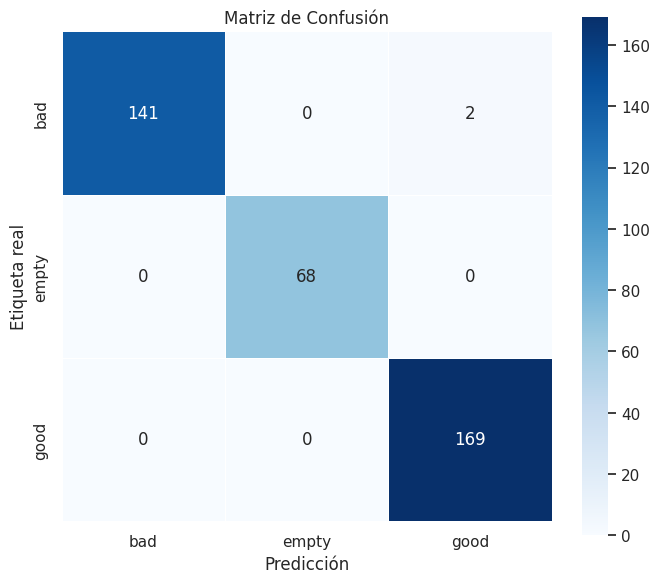

Total mal clasificadas en TODO el test: 2


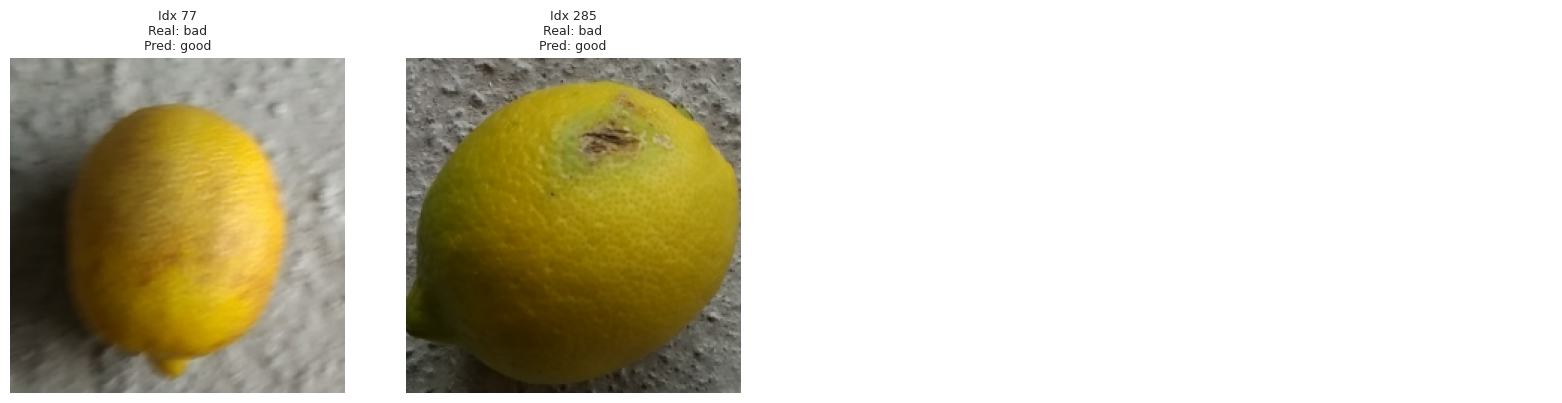

2

In [5]:
cm = tf_scratch_eval.get_confusion_matrix()
tf_scratch_eval.plot_confusion_matrix(save=True, show=True)
tf_scratch_eval.show_misclassified(max_images=9)

#### Evaluación del Modelo con Generator

In [6]:
gen_scratch_eval = LemonEvaluator(loader="gen", mode="scratch", attempt="eval")
gen_scratch_eval.prepare()
td = gen_scratch_eval.trainer.test_ds

gen_scratch_report=gen_scratch_eval.get_classification_report()
print(gen_scratch_report)

Found 316 validated image filenames belonging to 3 classes.
Found 1453 validated image filenames belonging to 3 classes.
Found 379 validated image filenames belonging to 3 classes.
Found 380 validated image filenames belonging to 3 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
              precision    recall  f1-score   support

         bad     1.0000    0.9790    0.9894       143
       empty     0.9855    1.0000    0.9927        68
        good     0.9825    0.9941    0.9882       169

    accuracy                         0.9895       380
   macro avg     0.9893    0.9910    0.9901       380
weighted avg     0.9896    0.9895    0.9895       380



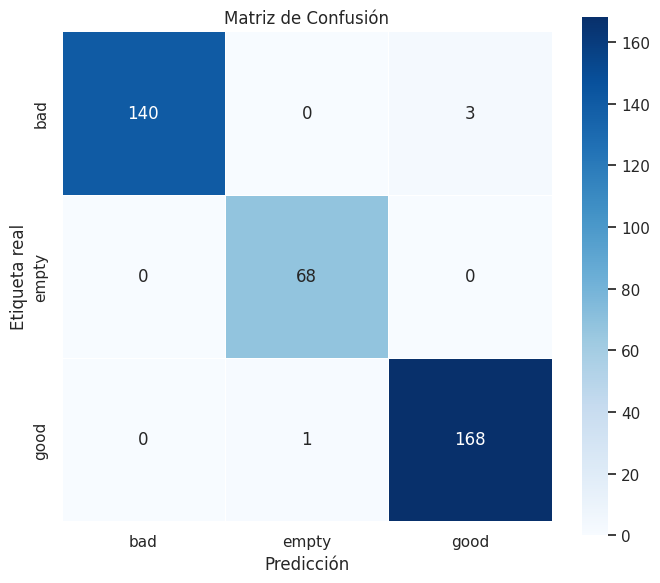

{'cm': array([[140,   0,   3],
        [  0,  68,   0],
        [  0,   1, 168]]),
 'path': './res_scratch/gen/eval_confusion_matrix.png'}

In [7]:
cm = gen_scratch_eval.get_confusion_matrix()
gen_scratch_eval.plot_confusion_matrix(save=True, show=True)

Total mal clasificadas en TODO el test: 4


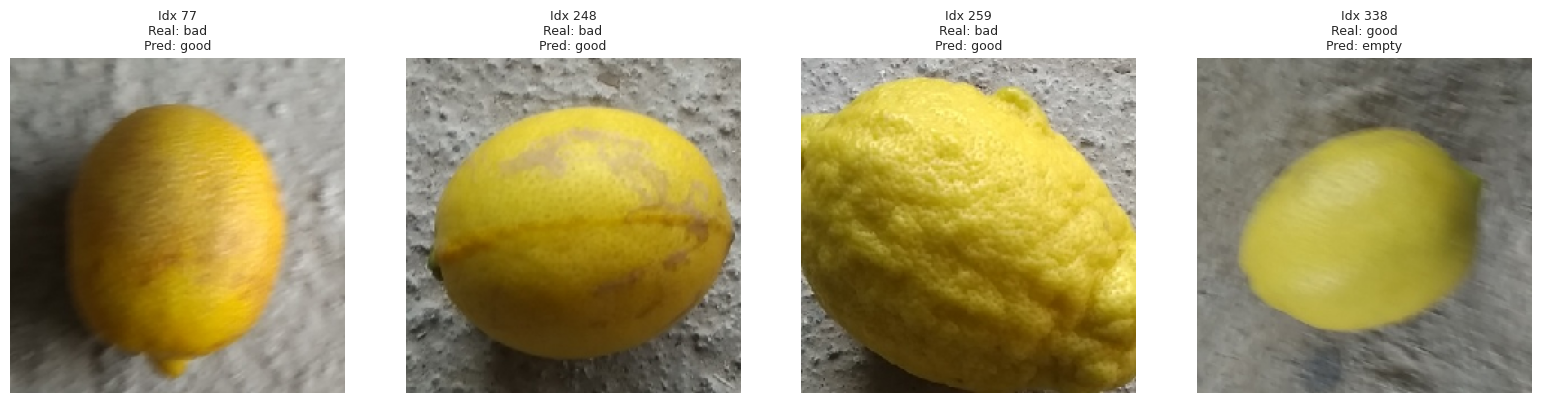

4

In [8]:
gen_scratch_eval.show_misclassified(max_images=9)

### 6.2 Estrategia 2: Red preentrenada


In [9]:
tf_transfer_eval = LemonEvaluator(loader="tf", mode="transfer", attempt="eval", model_variant="best_overall")

In [10]:
tf_transfer_eval.prepare()

FileNotFoundError: No existe el modelo 'best_overall' en: ./res_scratch/tf/eval_best_overall.keras
Tip: asegúrate de que attempt='eval' coincide con el entrenamiento.

In [ ]:

tf_transfer_report=tf_transfer_eval.classification_report()

tf_transfer_report
print(gen_scratch_report)
cm = gen_scratch_eval.confusion_matrix()
gen_scratch_eval.plot_confusion_matrix(save=True, show=True)
gen_scratch_eval.show_misclassified(max_images=9)

## **7. Conclusiones**